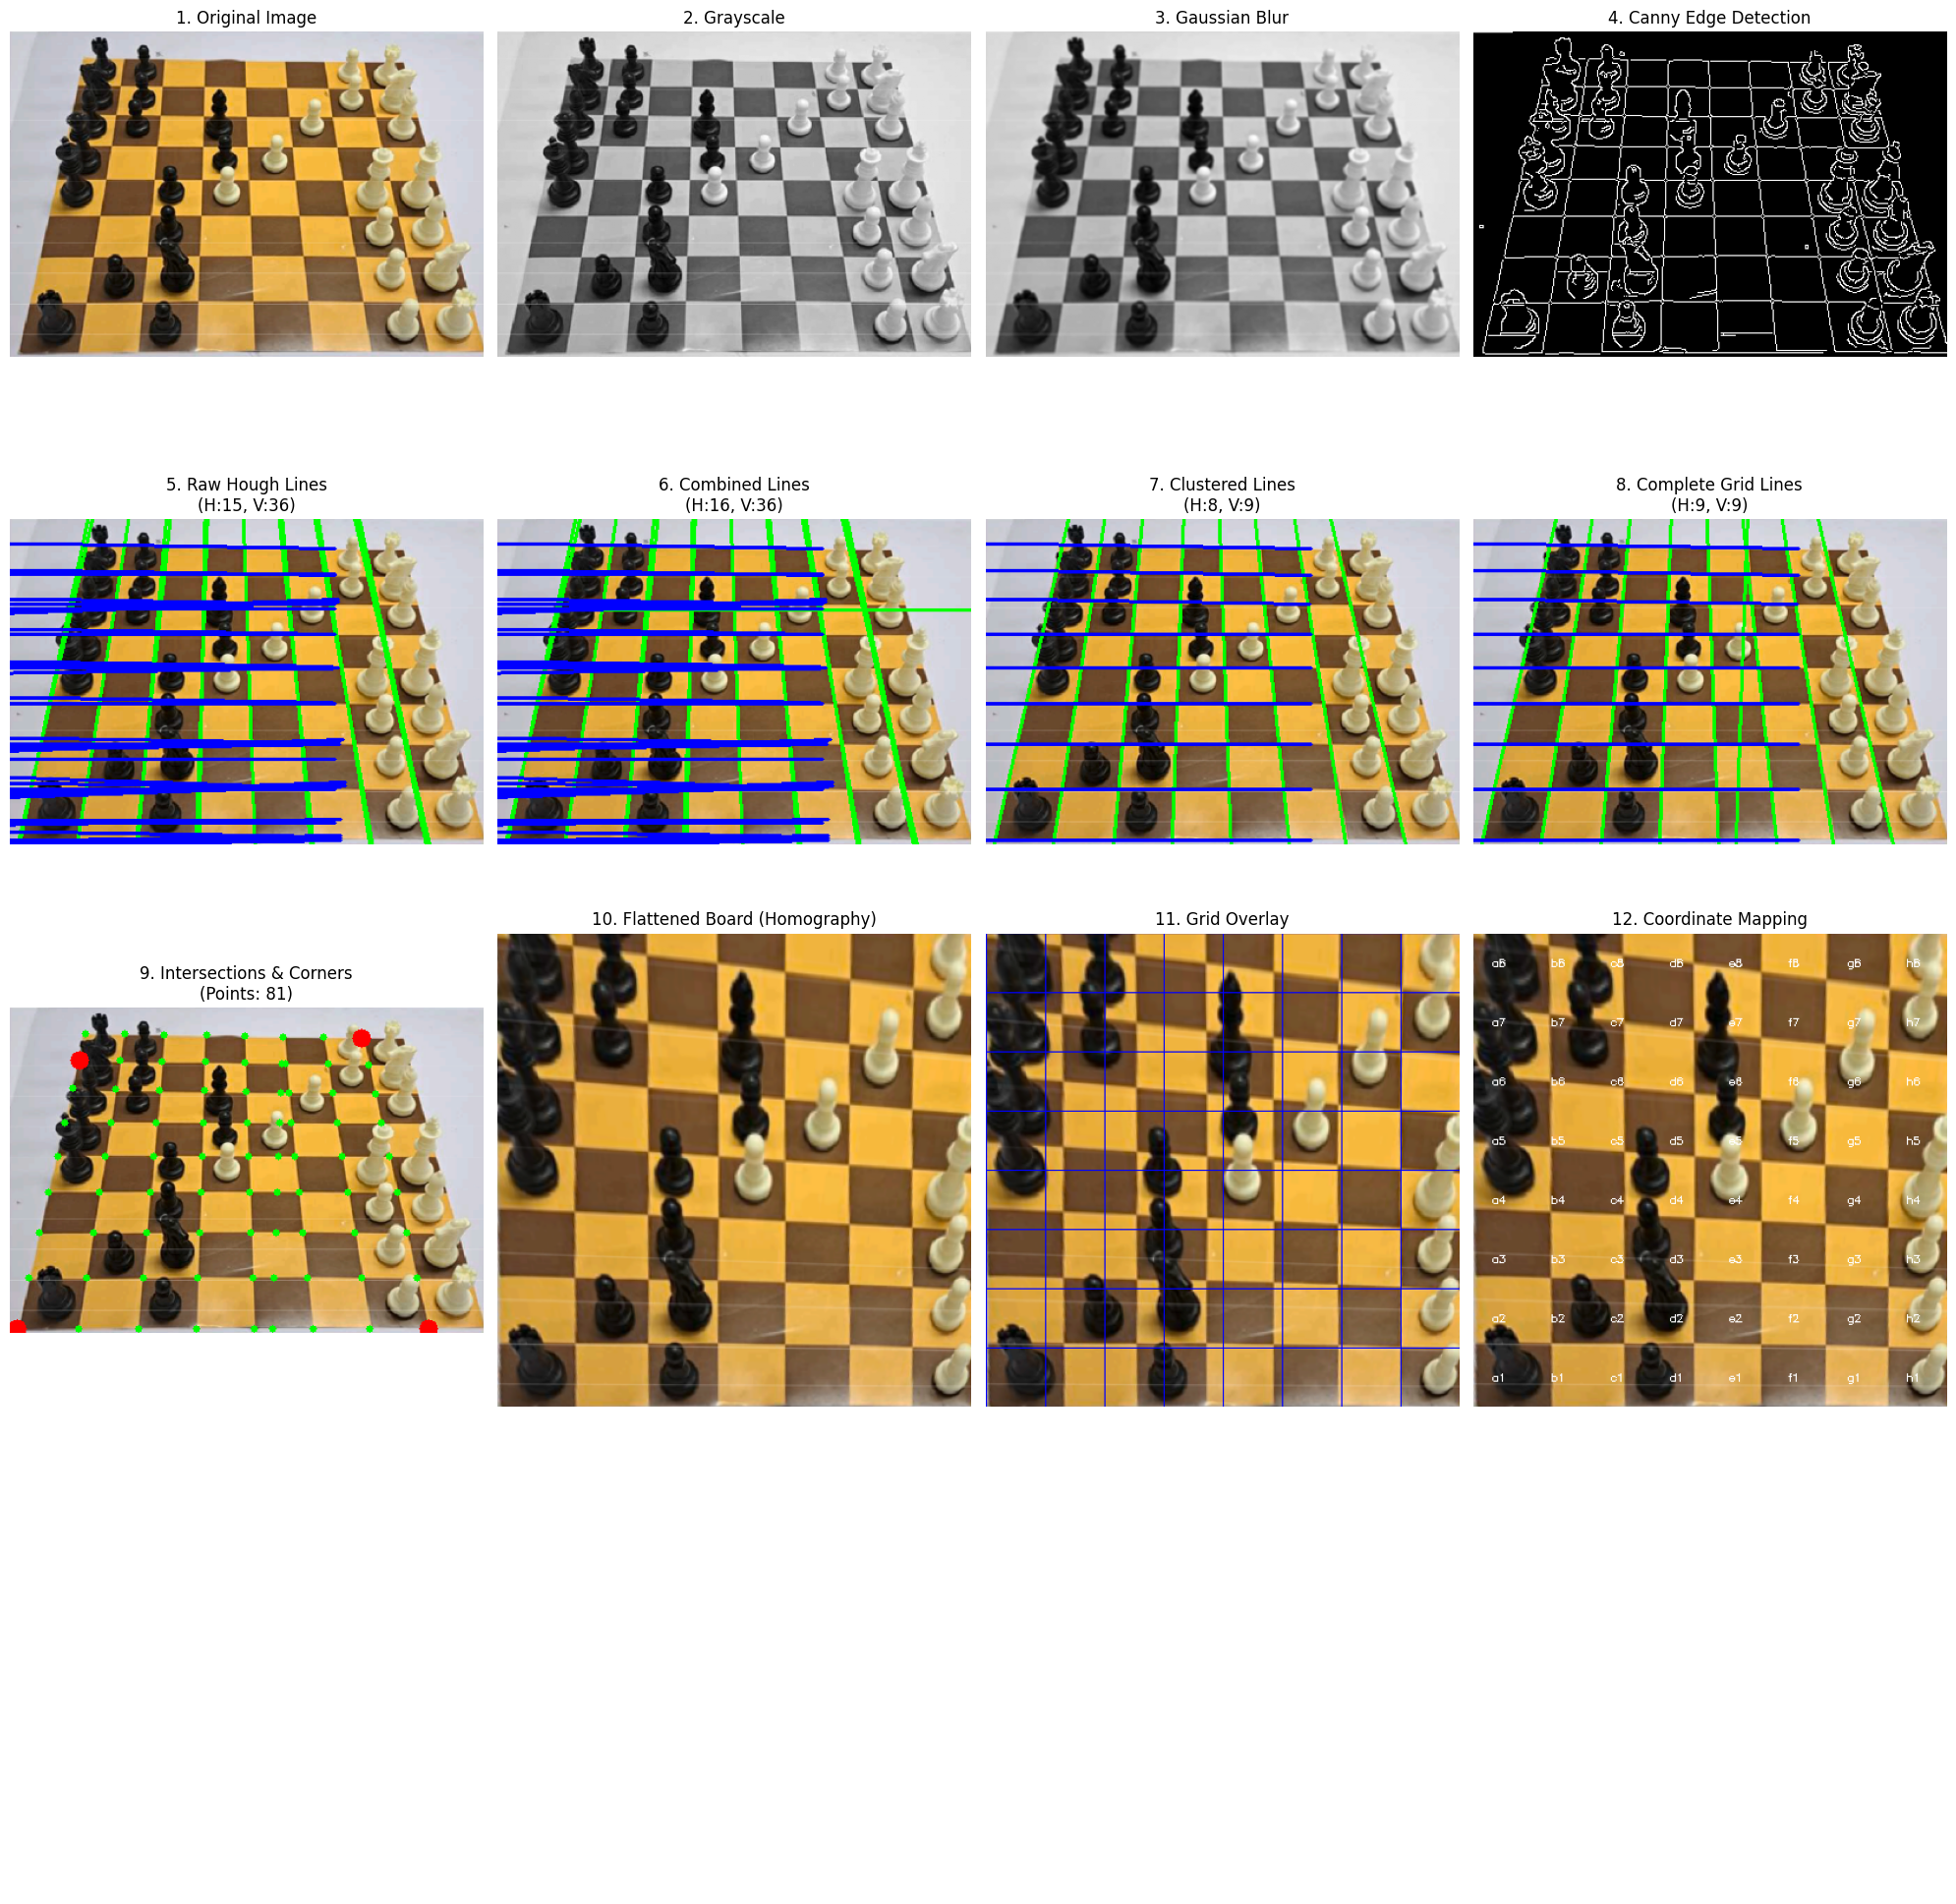

=== DETECTION STATISTICS ===
Raw Hough Lines - Horizontal: 15, Vertical: 36
Probabilistic Lines - Horizontal: 1, Vertical: 0
Combined Lines - Horizontal: 16, Vertical: 36
Clustered Lines - Horizontal: 8, Vertical: 9
Complete Lines - Horizontal: 9, Vertical: 9
Total Intersections: 81
Corners Detected: Yes
Homography Applied: Yes

Grid coordinates available!


In [75]:
import cv2
import numpy as np
from scipy import ndimage
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

class ChessBoardDetector:
    def __init__(self):
        self.board_corners = None
        self.grid_points = None

    def detect_board_canny(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blurred, 50, 150, apertureSize=3)
        return edges

    def detect_lines_hough(self, edges):
        lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=80)
        horizontal_lines = []
        vertical_lines = []

        if lines is not None:
            for line in lines:
                rho, theta = line[0]
                # Perketat toleransi untuk hanya horizontal dan vertikal murni
                if abs(theta) < np.pi/12 or abs(theta - np.pi) < np.pi/12:
                    horizontal_lines.append((rho, theta))
                elif abs(theta - np.pi/2) < np.pi/12:
                    vertical_lines.append((rho, theta))

        return horizontal_lines, vertical_lines

    def detect_lines_hough_probabilistic(self, edges):
        """Alternative menggunakan HoughLinesP untuk deteksi segment garis"""
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=250)

        horizontal_lines = []
        vertical_lines = []

        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]

                # Hitung sudut garis
                angle = np.arctan2(y2 - y1, x2 - x1)

                # Perketat toleransi untuk hanya horizontal dan vertikal murni
                if abs(angle) < np.pi/12 or abs(angle - np.pi) < np.pi/12 or abs(angle + np.pi) < np.pi/12:
                    # Horizontal line
                    rho = abs(y1 * np.cos(np.pi/2) + x1 * np.sin(np.pi/2))
                    theta = np.pi/2 if y1 > 0 else -np.pi/2
                    horizontal_lines.append((rho, theta))
                elif abs(angle - np.pi/2) < np.pi/12 or abs(angle + np.pi/2) < np.pi/12:
                    # Vertical line
                    rho = abs(x1 * np.cos(0) + y1 * np.sin(0))
                    theta = 0
                    vertical_lines.append((rho, theta))

        return horizontal_lines, vertical_lines

    def detect_board_canny_minimal(self, image):
        """Preprocessing minimal untuk fokus ke deteksi garis"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (3, 3), 0)
        edges = cv2.Canny(blurred, 30, 90, apertureSize=3)
        return edges

    def cluster_lines(self, lines, tolerance=15):
        if not lines:
            return []

        rhos = np.array([line[0] for line in lines]).reshape(-1, 1)
        clustering = DBSCAN(eps=tolerance, min_samples=1).fit(rhos)

        clustered_lines = []
        for cluster_id in set(clustering.labels_):
            cluster_lines = [lines[i] for i in range(len(lines)) if clustering.labels_[i] == cluster_id]
            # Pilih garis pertama di cluster (atau bisa pilih yang lain sesuai kebutuhan)
            chosen_line = cluster_lines[0]
            clustered_lines.append(chosen_line)

        return sorted(clustered_lines, key=lambda x: x[0])


    def complete_lines_to_grid(self, lines, is_horizontal=True, image_shape=None):
        """Melengkapi garis menjadi 9 garis untuk membentuk 8 petak"""
        if len(lines) == 0:
            return []
        
        if len(lines) >= 9:
            # Jika sudah cukup, ambil 9 yang terdistribusi merata
            indices = np.linspace(0, len(lines)-1, 9, dtype=int)
            return [lines[i] for i in indices]
        
        # Jika kurang dari 9, hitung jarak rata-rata dan tambahkan garis
        sorted_lines = sorted(lines, key=lambda x: x[0])
        
        if len(sorted_lines) < 2:
            return sorted_lines
        
        # Hitung jarak rata-rata antar garis
        distances = []
        for i in range(1, len(sorted_lines)):
            distances.append(abs(sorted_lines[i][0] - sorted_lines[i-1][0]))
        
        if len(distances) == 0:
            return sorted_lines
            
        avg_distance = np.mean(distances)
        
        completed_lines = sorted_lines.copy()
        
        # Tambahkan garis di awal jika perlu
        while len(completed_lines) < 9:
            first_rho = completed_lines[0][0]
            new_rho = first_rho - avg_distance
            
            # Cek apakah masih dalam batas gambar
            if new_rho > 0:
                theta = completed_lines[0][1]
                completed_lines.insert(0, (new_rho, theta))
            else:
                break
        
        # Tambahkan garis di akhir jika masih kurang
        while len(completed_lines) < 9:
            last_rho = completed_lines[-1][0]
            new_rho = last_rho + avg_distance
            
            # Cek batas gambar
            max_limit = image_shape[0] if is_horizontal else image_shape[1]
            if new_rho < max_limit:
                theta = completed_lines[-1][1]
                completed_lines.append((new_rho, theta))
            else:
                break
        
        return completed_lines[:9]

    def line_intersections(self, h_lines, v_lines):
        intersections = []

        for h_rho, h_theta in h_lines:
            for v_rho, v_theta in v_lines:
                A = np.array([[np.cos(h_theta), np.sin(h_theta)],
                             [np.cos(v_theta), np.sin(v_theta)]])
                b = np.array([h_rho, v_rho])

                try:
                    point = np.linalg.solve(A, b)
                    intersections.append((int(point[0]), int(point[1])))
                except np.linalg.LinAlgError:
                    continue

        return intersections

    def detect_board_corners(self, intersections, image_shape):
        if len(intersections) < 4:
            return None

        points = np.array(intersections)

        # Cari batas terluar
        min_x, min_y = np.min(points, axis=0)
        max_x, max_y = np.max(points, axis=0)

        # Fungsi cari titik terdekat
        def closest_point(target):
            distances = np.linalg.norm(points - target, axis=1)
            return tuple(points[np.argmin(distances)])

        # Cari masing-masing sudut
        top_left = closest_point((min_x, min_y))
        top_right = closest_point((max_x, min_y))
        bottom_right = closest_point((max_x, max_y))
        bottom_left = closest_point((min_x, max_y))

        corners = np.array([top_left, top_right, bottom_right, bottom_left], dtype=np.float32)
        return corners


    def apply_homography(self, image, corners):
        if corners is None:
            return image

        # Sort corners: top-left, top-right, bottom-right, bottom-left
        rect = np.zeros((4, 2), dtype=np.float32)
        s = corners.sum(axis=1)
        rect[0] = corners[np.argmin(s)]  # top-left
        rect[2] = corners[np.argmax(s)]  # bottom-right

        diff = np.diff(corners, axis=1)
        rect[1] = corners[np.argmin(diff)]  # top-right
        rect[3] = corners[np.argmax(diff)]  # bottom-left

        # Define destination points for 400x400 square
        dst = np.array([[0, 0], [400, 0], [400, 400], [0, 400]], dtype=np.float32)

        # Compute homography matrix
        M = cv2.getPerspectiveTransform(rect, dst)

        # Apply perspective transformation
        flattened = cv2.warpPerspective(image, M, (400, 400))

        return flattened

    def generate_grid_coordinates(self, size=400):
        coords = {}
        files = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
        ranks = ['8', '7', '6', '5', '4', '3', '2', '1']

        square_size = size // 8

        for i in range(8):
            for j in range(8):
                file_name = files[j]
                rank_name = ranks[i]
                square_name = file_name + rank_name

                x = j * square_size + square_size // 2
                y = i * square_size + square_size // 2

                coords[square_name] = (x, y)

        return coords

    def draw_lines(self, image, h_lines, v_lines):
        line_image = image.copy()
        height, width = image.shape[:2]

        # Draw horizontal lines
        for rho, theta in h_lines:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + width * (-b))
            y1 = int(y0 + width * (a))
            x2 = int(x0 - width * (-b))
            y2 = int(y0 - width * (a))
            cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Draw vertical lines
        for rho, theta in v_lines:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + height * (-b))
            y1 = int(y0 + height * (a))
            x2 = int(x0 - height * (-b))
            y2 = int(y0 - height * (a))
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 2)

        return line_image

    def process_image(self, image_path):
        # Load image
        image = cv2.imread(image_path)
        original_image = image.copy()

        # Step 1: Preprocessing - Gray and Blur
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (3, 3), 0)

        # Step 2: Edge Detection
        edges = self.detect_board_canny_minimal(image)

        # Step 3: Hough Line Transform (Raw)
        h_lines_raw, v_lines_raw = self.detect_lines_hough(edges)

        # Step 4: Probabilistic Hough (Raw)
        h_lines_prob, v_lines_prob = self.detect_lines_hough_probabilistic(edges)

        # Step 5: Combine lines
        h_lines_combined = h_lines_raw + h_lines_prob
        v_lines_combined = v_lines_raw + v_lines_prob

        # Step 6: Cluster lines
        h_lines_clustered = self.cluster_lines(h_lines_combined, tolerance=12)
        v_lines_clustered = self.cluster_lines(v_lines_combined, tolerance=12)

        # Step 7: Complete lines to 9 (untuk 8 petak)
        h_lines_complete = self.complete_lines_to_grid(h_lines_clustered, True, image.shape)
        v_lines_complete = self.complete_lines_to_grid(v_lines_clustered, False, image.shape)

        # Step 8: Draw overlays untuk setiap tahap
        lines_raw_overlay = self.draw_lines(image, h_lines_raw, v_lines_raw)
        lines_combined_overlay = self.draw_lines(image, h_lines_combined, v_lines_combined)
        lines_clustered_overlay = self.draw_lines(image, h_lines_clustered, v_lines_clustered)
        lines_complete_overlay = self.draw_lines(image, h_lines_complete, v_lines_complete)

        # Step 9: Line Intersections
        intersections = self.line_intersections(h_lines_complete, v_lines_complete)

        # Step 10: Detect board corners
        corners = self.detect_board_corners(intersections, image.shape)

        # Step 11: Homography transformation
        flattened_board = self.apply_homography(image, corners)

        # Step 12: Generate grid coordinates
        grid_coords = self.generate_grid_coordinates()

        return {
            'original': original_image,
            'gray': gray,
            'blurred': blurred,
            'edges': edges,
            'lines_raw_overlay': lines_raw_overlay,
            'lines_combined_overlay': lines_combined_overlay,
            'lines_clustered_overlay': lines_clustered_overlay,
            'lines_complete_overlay': lines_complete_overlay,
            'intersections': intersections,
            'corners': corners,
            'flattened': flattened_board,
            'grid_coordinates': grid_coords,
            'h_lines_raw_count': len(h_lines_raw),
            'v_lines_raw_count': len(v_lines_raw),
            'h_lines_prob_count': len(h_lines_prob),
            'v_lines_prob_count': len(v_lines_prob),
            'h_lines_combined_count': len(h_lines_combined),
            'v_lines_combined_count': len(v_lines_combined),
            'h_lines_clustered_count': len(h_lines_clustered),
            'v_lines_clustered_count': len(v_lines_clustered),
            'h_lines_complete_count': len(h_lines_complete),
            'v_lines_complete_count': len(v_lines_complete),
            'intersection_count': len(intersections)
        }

    def visualize_results(self, results):
        fig, axes = plt.subplots(4, 4, figsize=(20, 20))
        axes = axes.ravel()

        # Step 1: Original image
        axes[0].imshow(cv2.cvtColor(results['original'], cv2.COLOR_BGR2RGB))
        axes[0].set_title('1. Original Image')
        axes[0].axis('off')

        # Step 2: Grayscale
        axes[1].imshow(results['gray'], cmap='gray')
        axes[1].set_title('2. Grayscale')
        axes[1].axis('off')

        # Step 3: Blurred
        axes[2].imshow(results['blurred'], cmap='gray')
        axes[2].set_title('3. Gaussian Blur')
        axes[2].axis('off')

        # Step 4: Edge detection
        axes[3].imshow(results['edges'], cmap='gray')
        axes[3].set_title('4. Canny Edge Detection')
        axes[3].axis('off')

        # Step 5: Raw Hough lines
        axes[4].imshow(cv2.cvtColor(results['lines_raw_overlay'], cv2.COLOR_BGR2RGB))
        axes[4].set_title(f'5. Raw Hough Lines\n(H:{results["h_lines_raw_count"]}, V:{results["v_lines_raw_count"]})')
        axes[4].axis('off')

        # Step 6: Combined lines (Hough + Probabilistic)
        axes[5].imshow(cv2.cvtColor(results['lines_combined_overlay'], cv2.COLOR_BGR2RGB))
        axes[5].set_title(f'6. Combined Lines\n(H:{results["h_lines_combined_count"]}, V:{results["v_lines_combined_count"]})')
        axes[5].axis('off')

        # Step 7: Clustered lines
        axes[6].imshow(cv2.cvtColor(results['lines_clustered_overlay'], cv2.COLOR_BGR2RGB))
        axes[6].set_title(f'7. Clustered Lines\n(H:{results["h_lines_clustered_count"]}, V:{results["v_lines_clustered_count"]})')
        axes[6].axis('off')

        # Step 8: Complete grid lines
        axes[7].imshow(cv2.cvtColor(results['lines_complete_overlay'], cv2.COLOR_BGR2RGB))
        axes[7].set_title(f'8. Complete Grid Lines\n(H:{results["h_lines_complete_count"]}, V:{results["v_lines_complete_count"]})')
        axes[7].axis('off')

        # Step 9: Intersections
        img_intersections = results['original'].copy()
        for point in results['intersections']:
            cv2.circle(img_intersections, point, 3, (0, 255, 0), -1)
        if results['corners'] is not None:
            for corner in results['corners']:
                cv2.circle(img_intersections, tuple(corner.astype(int)), 8, (0, 0, 255), -1)

        axes[8].imshow(cv2.cvtColor(img_intersections, cv2.COLOR_BGR2RGB))
        axes[8].set_title(f'9. Intersections & Corners\n(Points: {results["intersection_count"]})')
        axes[8].axis('off')

        # Step 10: Flattened board
        if results['flattened'] is not None:
            axes[9].imshow(cv2.cvtColor(results['flattened'], cv2.COLOR_BGR2RGB))
            axes[9].set_title('10. Flattened Board (Homography)')
            axes[9].axis('off')

            # Step 11: Grid overlay on flattened board
            grid_overlay = results['flattened'].copy()
            for i in range(9):
                cv2.line(grid_overlay, (i*50, 0), (i*50, 400), (255, 0, 0), 1)
                cv2.line(grid_overlay, (0, i*50), (400, i*50), (255, 0, 0), 1)

            axes[10].imshow(cv2.cvtColor(grid_overlay, cv2.COLOR_BGR2RGB))
            axes[10].set_title('11. Grid Overlay')
            axes[10].axis('off')

            # Step 12: Coordinate mapping
            coord_overlay = results['flattened'].copy()
            files = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
            ranks = ['8', '7', '6', '5', '4', '3', '2', '1']

            for i in range(8):
                for j in range(8):
                    square_name = files[j] + ranks[i]
                    x, y = results['grid_coordinates'][square_name]
                    cv2.putText(coord_overlay, square_name, (x-10, y+3), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1)

            axes[11].imshow(cv2.cvtColor(coord_overlay, cv2.COLOR_BGR2RGB))
            axes[11].set_title('12. Coordinate Mapping')
            axes[11].axis('off')
        else:
            # Jika tidak ada flattened board
            axes[9].text(0.5, 0.5, 'Homography Failed\nNot enough corners', 
                        ha='center', va='center', transform=axes[9].transAxes, fontsize=12)
            axes[9].set_title('10. Flattened Board (Failed)')
            axes[9].axis('off')
            
            axes[10].text(0.5, 0.5, 'Grid Overlay\n(Not Available)', 
                         ha='center', va='center', transform=axes[10].transAxes, fontsize=12)
            axes[10].set_title('11. Grid Overlay (N/A)')
            axes[10].axis('off')
            
            axes[11].text(0.5, 0.5, 'Coordinate Mapping\n(Not Available)', 
                         ha='center', va='center', transform=axes[11].transAxes, fontsize=12)
            axes[11].set_title('12. Coordinate Mapping (N/A)')
            axes[11].axis('off')

        # Hide unused subplots
        for i in range(12, 16):
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

        # Print detailed statistics
        print("=== DETECTION STATISTICS ===")
        print(f"Raw Hough Lines - Horizontal: {results['h_lines_raw_count']}, Vertical: {results['v_lines_raw_count']}")
        print(f"Probabilistic Lines - Horizontal: {results['h_lines_prob_count']}, Vertical: {results['v_lines_prob_count']}")
        print(f"Combined Lines - Horizontal: {results['h_lines_combined_count']}, Vertical: {results['v_lines_combined_count']}")
        print(f"Clustered Lines - Horizontal: {results['h_lines_clustered_count']}, Vertical: {results['v_lines_clustered_count']}")
        print(f"Complete Lines - Horizontal: {results['h_lines_complete_count']}, Vertical: {results['v_lines_complete_count']}")
        print(f"Total Intersections: {results['intersection_count']}")
        print(f"Corners Detected: {'Yes' if results['corners'] is not None else 'No'}")
        print(f"Homography Applied: {'Yes' if results['flattened'] is not None else 'No'}")

# Usage
detector = ChessBoardDetector()
results = detector.process_image('chessboard2.png')
detector.visualize_results(results)

# Akses koordinat grid
if results['grid_coordinates'] is not None:
    grid_coordinates = results['grid_coordinates']
    print("\nGrid coordinates available!")
else:
    print("\nGrid coordinates not available - homography failed.")

=== EFFICIENT METHOD ===


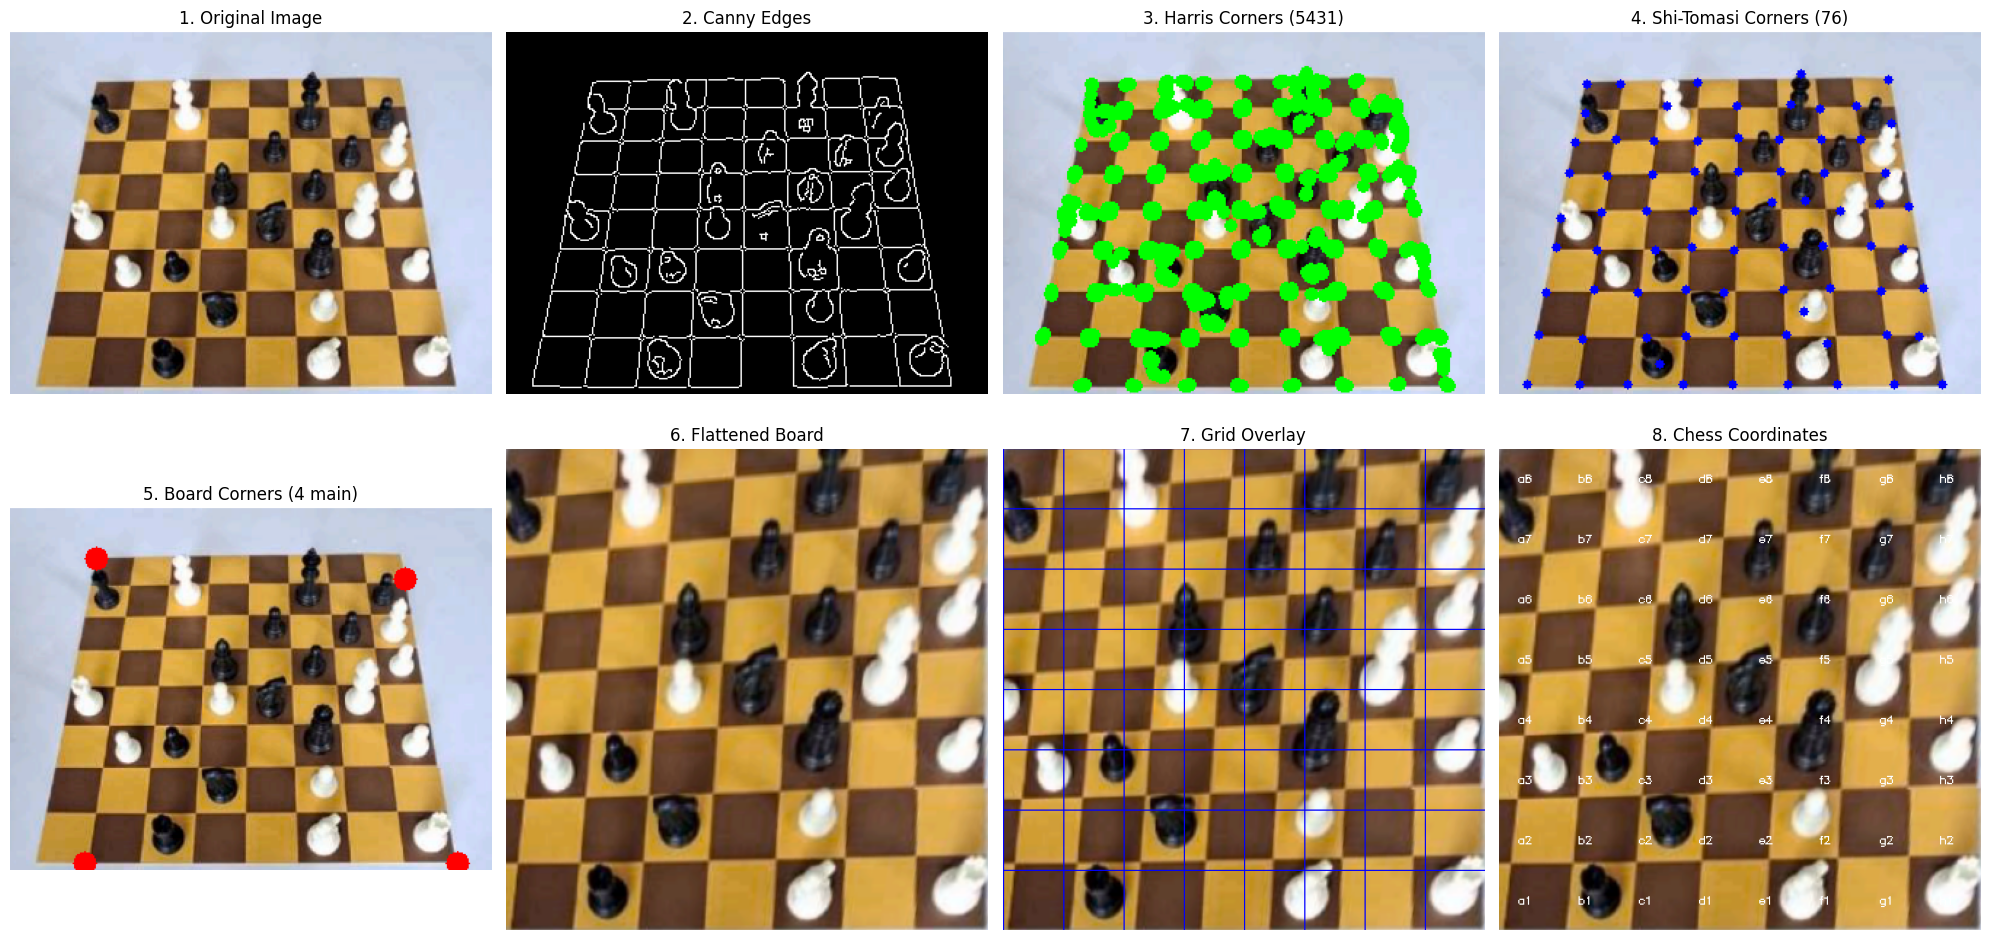

=== EFFICIENT DETECTION STATISTICS ===
Harris Corners Detected: 5431
Shi-Tomasi Corners Detected: 76
Board Corners Found: Yes
Homography Applied: Yes

Grid coordinates available!
Example coordinates:
a1: (25, 375)
h8: (375, 25)


In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

class EfficientChessBoardDetector:
    def __init__(self):
        self.board_corners = None

    def detect_corners_harris(self, image):
        """Deteksi corner menggunakan Harris Corner Detection"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        
        # Harris corner detection
        corners = cv2.cornerHarris(blurred, blockSize=2, ksize=3, k=0.04)
        
        # Dilate untuk menandai corner
        corners = cv2.dilate(corners, None)
        
        # Threshold untuk corner yang kuat
        threshold = 0.01 * corners.max()
        corner_points = np.where(corners > threshold)
        corner_coords = list(zip(corner_points[1], corner_points[0]))
        
        return corner_coords, corners

    def detect_corners_goodfeatures(self, image):
        """Deteksi corner menggunakan goodFeaturesToTrack (Shi-Tomasi)"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        
        # Shi-Tomasi corner detection
        corners = cv2.goodFeaturesToTrack(
            blurred, 
            maxCorners=200,
            qualityLevel=0.01,
            minDistance=20,
            blockSize=3
        )
        
        corner_coords = []
        if corners is not None:
            for corner in corners:
                x, y = corner.ravel()
                corner_coords.append((int(x), int(y)))
        
        return corner_coords

    def detect_board_corners_direct(self, corner_points, image_shape):
        """Deteksi 4 corner utama papan catur dari semua corner points"""
        if len(corner_points) < 4:
            return None
        
        points = np.array(corner_points)
        
        # Cari batas ekstrem
        min_x, min_y = np.min(points, axis=0)
        max_x, max_y = np.max(points, axis=0)
        
        # Fungsi untuk mencari corner terdekat dengan posisi target
        def find_closest_corner(target_x, target_y, tolerance=50):
            distances = np.sqrt((points[:, 0] - target_x)**2 + (points[:, 1] - target_y)**2)
            min_idx = np.argmin(distances)
            if distances[min_idx] < tolerance:
                return tuple(points[min_idx])
            return None
        
        # Cari 4 corner utama
        top_left = find_closest_corner(min_x, min_y)
        top_right = find_closest_corner(max_x, min_y)
        bottom_right = find_closest_corner(max_x, max_y)
        bottom_left = find_closest_corner(min_x, max_y)
        
        # Pastikan semua corner ditemukan
        corners = [top_left, top_right, bottom_right, bottom_left]
        if None in corners:
            return None
            
        return np.array(corners, dtype=np.float32)

    def apply_homography(self, image, corners):
        """Aplikasi homography untuk meratakan papan"""
        if corners is None:
            return None
            
        # Urutkan corners: top-left, top-right, bottom-right, bottom-left
        rect = np.zeros((4, 2), dtype=np.float32)
        s = corners.sum(axis=1)
        rect[0] = corners[np.argmin(s)]  # top-left
        rect[2] = corners[np.argmax(s)]  # bottom-right
        
        diff = np.diff(corners, axis=1)
        rect[1] = corners[np.argmin(diff)]  # top-right  
        rect[3] = corners[np.argmax(diff)]  # bottom-left
        
        # Target destination (400x400 square)
        dst = np.array([[0, 0], [400, 0], [400, 400], [0, 400]], dtype=np.float32)
        
        # Hitung homography matrix
        M = cv2.getPerspectiveTransform(rect, dst)
        
        # Aplikasi perspective transformation
        flattened = cv2.warpPerspective(image, M, (400, 400))
        
        return flattened

    def generate_grid_coordinates(self, size=400):
        """Generate koordinat grid untuk setiap kotak catur"""
        coords = {}
        files = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
        ranks = ['8', '7', '6', '5', '4', '3', '2', '1']
        
        square_size = size // 8
        
        for i in range(8):
            for j in range(8):
                file_name = files[j]
                rank_name = ranks[i]
                square_name = file_name + rank_name
                
                x = j * square_size + square_size // 2
                y = i * square_size + square_size // 2
                
                coords[square_name] = (x, y)
                
        return coords

    def process_image_efficient(self, image_path):
        """Proses efisien: Edge -> Corner -> Homography"""
        # Load image
        image = cv2.imread(image_path)
        original = image.copy()
        
        # Step 1: Preprocessing
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        
        # Step 2: Edge Detection (opsional untuk visualisasi)
        edges = cv2.Canny(blurred, 50, 150, apertureSize=3)
        
        # Step 3: Direct Corner Detection
        harris_corners, harris_response = self.detect_corners_harris(image)
        shi_tomasi_corners = self.detect_corners_goodfeatures(image)
        
        # Step 4: Detect Board Corners (coba kedua metode)
        board_corners_harris = self.detect_board_corners_direct(harris_corners, image.shape)
        board_corners_shi = self.detect_board_corners_direct(shi_tomasi_corners, image.shape)
        
        # Pilih yang terbaik atau gabungkan
        best_corners = board_corners_harris if board_corners_harris is not None else board_corners_shi
        
        # Step 5: Apply Homography
        flattened = self.apply_homography(image, best_corners)
        
        # Step 6: Generate Grid Coordinates
        grid_coords = self.generate_grid_coordinates() if flattened is not None else None
        
        return {
            'original': original,
            'gray': gray,
            'blurred': blurred,
            'edges': edges,
            'harris_corners': harris_corners,
            'harris_response': harris_response,
            'shi_tomasi_corners': shi_tomasi_corners,
            'board_corners_harris': board_corners_harris,
            'board_corners_shi': board_corners_shi,
            'best_corners': best_corners,
            'flattened': flattened,
            'grid_coordinates': grid_coords
        }

    def visualize_efficient_results(self, results):
        """Visualisasi hasil deteksi efisien"""
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        axes = axes.ravel()
        
        # 1. Original Image
        axes[0].imshow(cv2.cvtColor(results['original'], cv2.COLOR_BGR2RGB))
        axes[0].set_title('1. Original Image')
        axes[0].axis('off')
        
        # 2. Edge Detection
        axes[1].imshow(results['edges'], cmap='gray')
        axes[1].set_title('2. Canny Edges')
        axes[1].axis('off')
        
        # 3. Harris Corner Detection
        img_harris = results['original'].copy()
        for corner in results['harris_corners']:
            cv2.circle(img_harris, corner, 3, (0, 255, 0), -1)
        axes[2].imshow(cv2.cvtColor(img_harris, cv2.COLOR_BGR2RGB))
        axes[2].set_title(f'3. Harris Corners ({len(results["harris_corners"])})')
        axes[2].axis('off')
        
        # 4. Shi-Tomasi Corner Detection
        img_shi = results['original'].copy()
        for corner in results['shi_tomasi_corners']:
            cv2.circle(img_shi, corner, 3, (255, 0, 0), -1)
        axes[3].imshow(cv2.cvtColor(img_shi, cv2.COLOR_BGR2RGB))
        axes[3].set_title(f'4. Shi-Tomasi Corners ({len(results["shi_tomasi_corners"])})')
        axes[3].axis('off')
        
        # 5. Board Corners Detection
        img_board_corners = results['original'].copy()
        if results['best_corners'] is not None:
            for corner in results['best_corners']:
                cv2.circle(img_board_corners, tuple(corner.astype(int)), 8, (0, 0, 255), -1)
        axes[4].imshow(cv2.cvtColor(img_board_corners, cv2.COLOR_BGR2RGB))
        axes[4].set_title('5. Board Corners (4 main)')
        axes[4].axis('off')
        
        # 6. Flattened Board
        if results['flattened'] is not None:
            axes[5].imshow(cv2.cvtColor(results['flattened'], cv2.COLOR_BGR2RGB))
            axes[5].set_title('6. Flattened Board')
            axes[5].axis('off')
            
            # 7. Grid Overlay
            grid_overlay = results['flattened'].copy()
            for i in range(9):
                cv2.line(grid_overlay, (i*50, 0), (i*50, 400), (255, 0, 0), 1)
                cv2.line(grid_overlay, (0, i*50), (400, i*50), (255, 0, 0), 1)
            axes[6].imshow(cv2.cvtColor(grid_overlay, cv2.COLOR_BGR2RGB))
            axes[6].set_title('7. Grid Overlay')
            axes[6].axis('off')
            
            # 8. Chess Coordinates
            coord_overlay = results['flattened'].copy()
            files = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
            ranks = ['8', '7', '6', '5', '4', '3', '2', '1']
            
            for i in range(8):
                for j in range(8):
                    square_name = files[j] + ranks[i]
                    x, y = results['grid_coordinates'][square_name]
                    cv2.putText(coord_overlay, square_name, (x-10, y+3), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1)
            
            axes[7].imshow(cv2.cvtColor(coord_overlay, cv2.COLOR_BGR2RGB))
            axes[7].set_title('8. Chess Coordinates')
            axes[7].axis('off')
        else:
            axes[5].text(0.5, 0.5, 'Homography Failed', ha='center', va='center', 
                        transform=axes[5].transAxes, fontsize=12)
            axes[5].set_title('6. Flattened Board (Failed)')
            axes[5].axis('off')
            
            for i in range(6, 8):
                axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Print statistics
        print("=== EFFICIENT DETECTION STATISTICS ===")
        print(f"Harris Corners Detected: {len(results['harris_corners'])}")
        print(f"Shi-Tomasi Corners Detected: {len(results['shi_tomasi_corners'])}")
        print(f"Board Corners Found: {'Yes' if results['best_corners'] is not None else 'No'}")
        print(f"Homography Applied: {'Yes' if results['flattened'] is not None else 'No'}")

# Usage - Efficient Method
print("=== EFFICIENT METHOD ===")
efficient_detector = EfficientChessBoardDetector()
efficient_results = efficient_detector.process_image_efficient('chessboard1.png')
efficient_detector.visualize_efficient_results(efficient_results)

# Akses koordinat grid
if efficient_results['grid_coordinates'] is not None:
    grid_coordinates = efficient_results['grid_coordinates']
    print("\nGrid coordinates available!")
    print("Example coordinates:")
    print(f"a1: {grid_coordinates['a1']}")
    print(f"h8: {grid_coordinates['h8']}")
else:
    print("\nGrid coordinates not available - homography failed.")